In [100]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error

In [26]:
df = pd.read_csv('/kaggle/input/apple-stock-20132018/AAPL.xls',index_col="Date",parse_dates=True)
df.head()

,Open
Date,
2013-01-02,79.117142
2013-01-03,78.268570
2013-01-04,76.709999
2013-01-07,74.571426
2013-01-08,75.601425


In [99]:
test_data.shape

(20, 1)

In [28]:
df.describe()

,Open
count,1259.000000
mean,106.953082
std,29.630323
min,55.424286
25%,79.675716
50%,107.879997
75%,125.994999
max,175.110001


# Visualize the time series

In [29]:
# Line plot of 'Open' prices over time
fig = px.line(df, x=df.index, y='Open', title='Apple Stock Open Prices Over Time',width=900, height=500)
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Open Price (USD)',
    title={
        'text': "Apple Stock Open Prices Over Time",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

# Format the date labels on the x-axis
fig.update_xaxes(
    tickformat="%b %Y",  # Month and year format
    tickangle=-45  # Rotate labels to avoid overlap
)

# Optional: Adjust the line color or style
fig.update_traces(line_color='green', line_dash='solid')

# Display the improved plot
fig.show()


#  Time-series decomposition

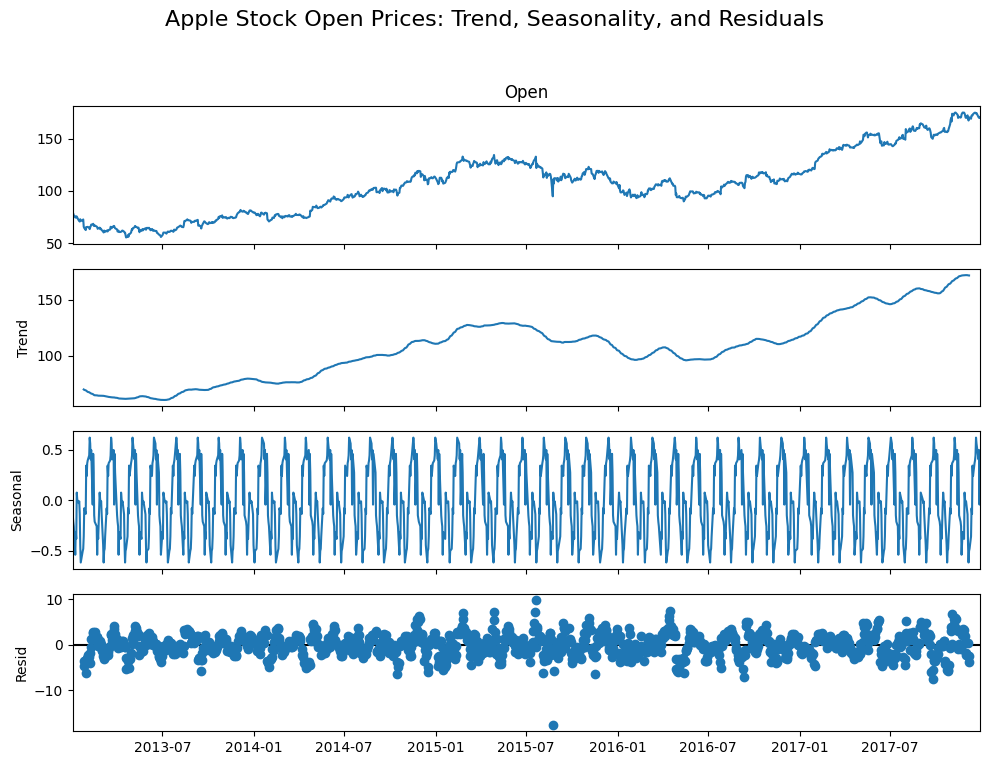

In [30]:
decomposition = sm.tsa.seasonal_decompose(df['Open'], model='additive', period=30)

# Plot the decomposition components
fig = decomposition.plot()

fig.set_size_inches(10, 8)  # Width = 10 inches, Height = 8 inches

fig.suptitle('Apple Stock Open Prices: Trend, Seasonality, and Residuals', fontsize=16)

# Adjust the spacing of the subplots to make them fit better
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the updated plot
plt.show()


# Check if a time series is stationary or non-stationary

In [31]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the 'Open' prices
result = adfuller(df['Open'])

# Extract the test statistics and p-value
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4] 

# Print results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Conclusion based on the p-value
if p_value < 0.05:
    print("The time series is stationary (reject the null hypothesis)")
else:
    print("The time series is non-stationary (fail to reject the null hypothesis)")


ADF Statistic: 0.13197898904401384
p-value: 0.9681778344384847
Critical Values:
   1%: -3.4355629707955395
   5%: -2.863842063387667
   10%: -2.567995644141416
The time series is non-stationary (fail to reject the null hypothesis)


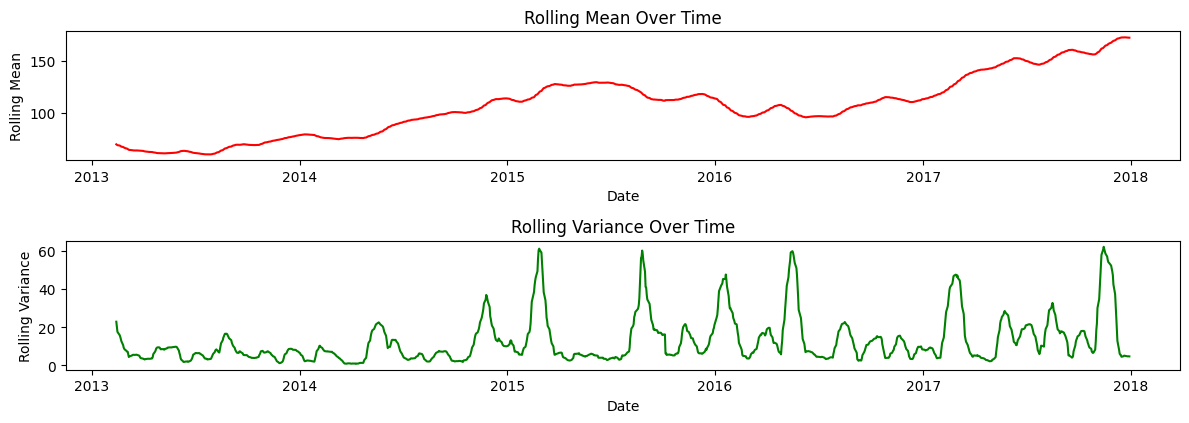

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

# Calculate rolling statistics (mean and variance) over a window
window_size = 30  # Change this based on the granularity you need

# Rolling mean
rolling_mean = df['Open'].rolling(window=window_size).mean()

# Rolling variance
rolling_variance = df['Open'].rolling(window=window_size).var()

# Plot Rolling Mean and Variance
plt.figure(figsize=(12, 6))

# Plot rolling mean
plt.subplot(3, 1, 1)
plt.plot(rolling_mean, label=f'Rolling Mean (window={window_size})', color='red')
plt.title('Rolling Mean Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Mean')

# Plot rolling variance
plt.subplot(3, 1, 2)
plt.plot(rolling_variance, label=f'Rolling Variance (window={window_size})', color='green')
plt.title('Rolling Variance Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Variance')

plt.tight_layout()
plt.show()



<Figure size 800x600 with 0 Axes>

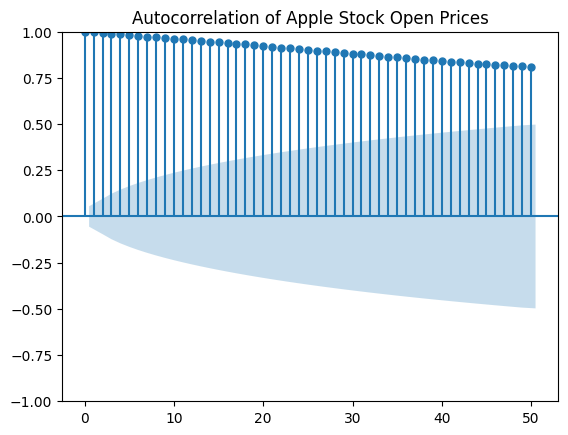

In [33]:
# Plot Autocorrelation
plt.figure(figsize=(8, 6))
plot_acf(df['Open'].dropna(), lags=50)
plt.title('Autocorrelation of Apple Stock Open Prices')
plt.show()

> ### One of the key strengths of RNNs and LSTMs is their ability to handle non-stationary data.

# Normalization

In [350]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Open']])
scaled_test_data = scaler.transform(test_data[['Open']])

# Preparing the Data for RNN/LSTM

In [351]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [352]:
# Specify the time step
time_step = 60
# Prepare training data
X_train, Y_train = create_dataset(scaled_data, time_step)

In [353]:
# Split the data into training and validation sets
train_size = int(len(X_train) * 0.7)  # 70% for training
X_val = X_train[train_size:]  # 30% for validation
Y_val = Y_train[train_size:]
X_train = X_train[:train_size]
Y_train = Y_train[:train_size]

# Build and Train an LSTM Model

In [354]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,SimpleRNN,Input

In [384]:
LSTM_model = Sequential()
LSTM_model.add(Input(shape=(time_step, 1)))  # Input layer
LSTM_model.add(LSTM(units=400, return_sequences=True))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(LSTM(units=100, return_sequences=False))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(units=100))
LSTM_model.add(Dense(units=1))  # Output layer (single prediction)

# Compile the model
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

LSTM_model.summary()
# Train the model
history = LSTM_model.fit(X_train, Y_train, batch_size=64, epochs=200,validation_data=(X_val, Y_val))

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                  │ (None, 60, 400)        │       643,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 60, 400)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_85 (LSTM)                  │ (None, 100)            │       200,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,801 (3.26 MB)

 Trainable params: 853,801 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0461 - val_loss: 0.0134
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014 - val_loss: 8.0094e-04
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012 - val_loss: 6.7394e-04
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.8714e-04 - val_loss: 8.7138e-04
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.6314e-04 - val_loss: 7.4496e-04
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.4950e-04 - val_loss: 6.5027e-04
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0010 - val_loss: 8.9450e-04
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.7985e-04 - val_loss: 0.0074
Epoch 12/200

# Visualize the Training and Validation Loss

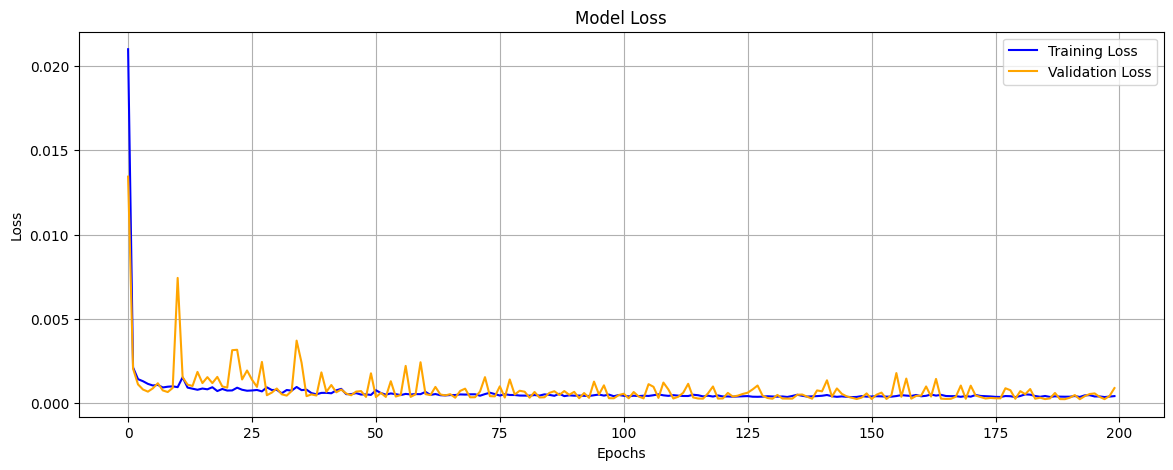

In [385]:
# Plotting training and validation loss
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [390]:
# Prepare the test data
X_test, Y_test = create_dataset(scaled_test_data, 3)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Predicting the test data
predicted_prices = LSTM_model.predict(X_test)

# Inverse transform the predicted values
lstm_predictions = scaler.inverse_transform(predicted_prices)

# Inverse transform the actual values
actual_prices = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices, lstm_predictions))
print(f"Root Mean Squared Error: {rmse}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Root Mean Squared Error: 3.496719996471637


# Creating the RNN Model

In [358]:
RNN_model  = Sequential()
RNN_model .add(Input(shape=(time_step, 1)))  # Input layer
RNN_model .add(SimpleRNN(units=300, return_sequences=True))
RNN_model .add(Dropout(0.2))
RNN_model .add(SimpleRNN(units=200, return_sequences=False))
RNN_model .add(Dense(units=100))
RNN_model .add(Dense(units=1))  # Output layer (single prediction)

# Compile the model
RNN_model .compile(optimizer='adam', loss='mean_squared_error')

RNN_model .summary()
# Train the model
history = RNN_model .fit(X_train, Y_train, batch_size=64, epochs=200,validation_data=(X_val, Y_val))

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_14 (SimpleRNN)       │ (None, 60, 300)        │        90,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 60, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,001 (824.22 KB)

 Trainable params: 211,001 (824.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - loss: 1.6085 - val_loss: 0.0562
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0705 - val_loss: 0.0062
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0237 - val_loss: 0.0152
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0119 - val_loss: 0.0057
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0086 - val_loss: 0.0263
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste

# Visualize the Training and Validation Loss

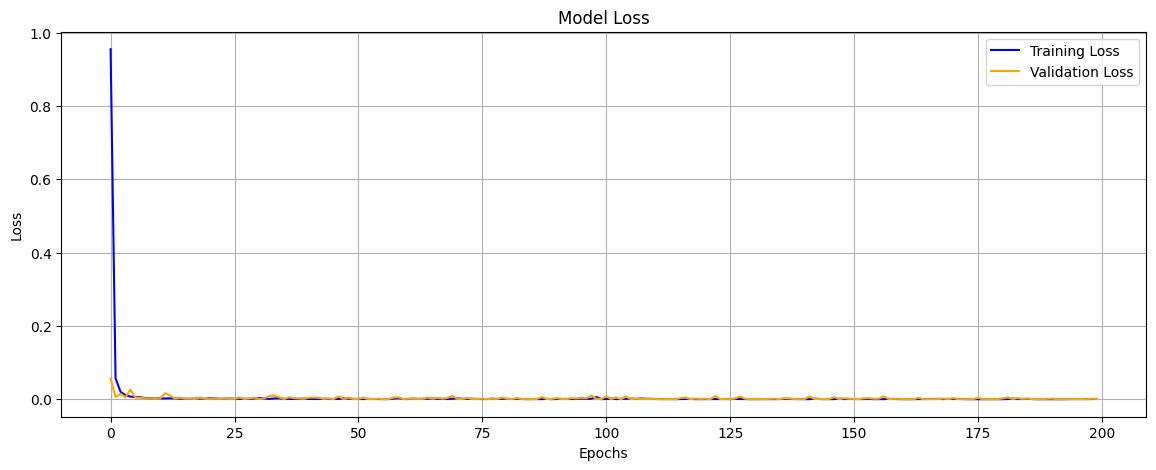

In [359]:
# Plotting training and validation loss
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [389]:
# Prepare the test data
X_test, Y_test = create_dataset(scaled_test_data,3 )
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Predicting the test data
predicted_prices = RNN_model.predict(X_test)

# Inverse transform the predicted values
rnn_predictions = scaler.inverse_transform(predicted_prices)

# Inverse transform the actual values
actual_prices = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices, rnn_predictions))
print(f"Root Mean Squared Error: {rmse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Root Mean Squared Error: 4.06237833269686


In [391]:
actual_values = scaler.inverse_transform(Y_test.reshape(-1, 1))
# Step 4: Create a DataFrame with Actual, LSTM Predictions, and RNN Predictions
comparison_df = pd.DataFrame({
    'Actual': actual_values.flatten(),  # Convert to 1D array
    'LSTM_Predicted': lstm_predictions.flatten(),
    'RNN_Predicted': rnn_predictions.flatten()
})

# Step 5: Display the table (this can be printed or viewed in a Jupyter notebook)
print(comparison_df)

# Optionally, save it to a CSV if needed
comparison_df.to_csv('predictions_comparison.csv', index=False)

        Actual  LSTM_Predicted  RNN_Predicted
0   173.440002      169.511856     169.251877
1   174.350006      170.125702     169.698792
2   174.550003      170.941299     170.548325
3   173.160004      171.377838     170.853256
4   174.589996      170.664001     169.895737
5   176.179993      171.065063     170.495102
6   177.899994      172.393799     172.039948
7   176.149994      173.948578     173.505203
8   179.369995      173.525818     172.644699
9   178.610001      174.912842     174.247162
10  177.300003      175.419067     174.677658
11  177.300003      174.530075     173.368149
12  177.250000      174.092392     173.091766
13  174.509995      174.017273     173.153687
14  172.000000      172.406387     171.289627
15  170.160004      170.080643     168.889725
